# Recommendations with IBM

In this notebook, we will use a number of different methods for making recommendations in different situations using real data from the IBM Watson Studio platform. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

df = pd.read_csv('user-item-interactions.csv')
df_content = pd.read_csv('articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Providing some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset? <br>
Visual and descriptive statistics on the number of times each user interacts with an article.  

In [3]:
df.describe()

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
25%,460.000000
50%,1151.000000
75%,1336.000000
max,1444.000000


In [4]:
df_content.describe()

,article_id
count,1056.000000
mean,523.913826
std,303.480641
min,0.000000
25%,260.750000
50%,523.500000
75%,786.250000
max,1050.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [6]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


In [7]:
# user interactions with the articles
df['email'].value_counts().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

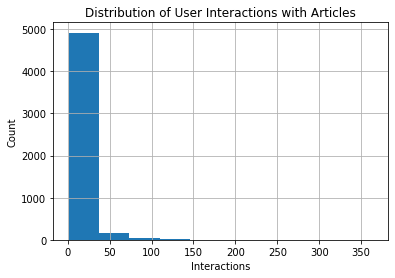

In [8]:
# plotting the user interactions

df['email'].value_counts().hist()
plt.title('Distribution of User Interactions with Articles')
plt.xlabel('Interactions')
plt.ylabel('Count')
plt.show()

In [9]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is 364.

`2.` Exploring and removing duplicate articles from the **df_content** dataframe.  

In [10]:
# Find and explore duplicate articles
df_content.duplicated().sum()

0

In [11]:
df_content.duplicated(['article_id']).sum()

5

In [12]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)

`3.` Finding:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [13]:
print(df.article_id.nunique()) # a
print(df_content.article_id.nunique()) # b
print(df.email.nunique()) # c
print(df.shape[0]) # d

714
1051
5148
45993


In [14]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Finding the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user.

In [15]:
df.article_id.value_counts().max()

937

In [16]:
df.article_id.value_counts().head()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [17]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [18]:
# Mapping the user email to a user_id column and removing the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
dict1 = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}
print (dict1)

{'`50% of individuals have _____ or fewer interactions.`': 3, '`The total number of user-article interactions in the dataset is ______.`': 45993, '`The maximum number of user-article interactions by any 1 user is ______.`': 364, '`The most viewed article in the dataset was viewed _____ times.`': 937, '`The article_id of the most viewed article is ______.`': '1429.0', '`The number of unique articles that have at least 1 rating ______.`': 714, '`The number of unique users in the dataset is ______`': 5148, '`The number of unique articles on the IBM platform`': 1051}


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

The popularity of an article can be found by how often an article was interacted with.

`1.` Finding the **n** top articles ordered with most interactions as the top.

In [20]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    toparticles= df.groupby(by='title').count().sort_values(by='user_id', ascending=False)
    top_articles= list(toparticles.head(n).index)
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    toparticlesid= df.groupby(by='article_id').count().sort_values(by='user_id', ascending=False)
    top_articles= list(toparticlesid.head(n).index)
 
    return top_articles

In [21]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Reformatting the **df** dataframe to be shaped with users as the rows and articles as the columns, so that:  

* Each **user** only appears in each **row** once.


* Each **article** only appears in one **column**.  


* **If a user has interacted with an article, then we place a 1 where the user-row meets that article-column**.


* **If a user has not interacted with an item, then we place a zero where the user-row meets for that article-column**. 


In [22]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item = user_item.notnull().astype(int)
    
    return user_item

user_item = create_user_item_matrix(df)

In [23]:
# taking a look at our matrix
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` Taking a user_id and providing an ordered list of the most similar users to that user (from most similar to least similar). Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [24]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # computing similarity of each user to the provided user
    similar = user_item.dot(user_item.loc[user_id])
    
    # sorting by similarity
    similar_sorted = similar.sort_values(ascending=False)
    
    # creating list of just the ids
    most_similar_users = list(similar_sorted.index)
    
    # removing the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # returning a list of the users in order from most to least similar
        

In [25]:
# Checking
print("The 10 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:10]))

The 10 most similar users to user 3933 are: [1, 23, 3782, 4459, 203, 4201, 3870, 131, 46, 5041]


`3.` Using these users to find articles we can recommend.

In [26]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    for x in article_ids:
        y = df[df['article_id'] == float(x)]['title'].iloc[0]
        article_names.append(y)
        
    return article_names 


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = []
    for x in user_item.columns:
        if user_item.loc[user_id, x] == 1:
            article_ids.append(str(x))

    article_names = get_article_names(article_ids)
    
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    seen_ids, seen_names = get_user_articles(user_id)
    recs = []
    most_similar_users = find_similar_users(user_id)
    
    for x in most_similar_users:
        article_ids, article_names = get_user_articles(x)
        
        for y in article_ids:
            if y not in seen_ids:
                recs.append(y)
        if len(recs) >=m:
                break
    recs=recs[:m]
    
    return recs

In [27]:
# Returning 15 recommendations for user 15
get_article_names(user_user_recs(15, 15)) # 

['how to map usa rivers using ggplot2',
 'how to scale your analytics using r',
 'pixiedust: magic for your python notebook',
 'd3heatmap: interactive heat maps',
 'common excel tasks demonstrated in\xa0pandas',
 "december '16 rstudio tips and tricks",
 'twelve\xa0ways to color a map of africa using brunel',
 'using machine learning to predict value of homes on airbnb',
 'dt: an r interface to the datatables library',
 'pixiedust gets its first community-driven feature in 1.0.4',
 'flexdashboard: interactive dashboards for r',
 'tidy data in python',
 'using rstudio in ibm data science experience',
 'use the cloudant-spark connector in python notebook',
 'workflow in r']

`4.` To improve the consistency of the **user_user_recs** function, we"  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - we choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we choose articles with the articles with the most total interactions before choosing those with fewer total interactions.

In [28]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    similar = user_item.dot(user_item.loc[user_id])
    similar_sorted = similar.sort_values(ascending=False)
    similar_sorted = similar_sorted.drop(user_id).to_frame(name='similarity')
    similar_sorted= similar_sorted.reset_index()
    num_interactions = df['user_id'].value_counts().to_frame('num_interactions')
    neighbors_df = similar_sorted.merge(num_interactions, left_on='user_id', right_index=True)
    neighbors_df.rename(columns={'user_id':'neighbor_id'}, inplace=True)
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    seen_ids = get_user_articles(user_id)[0]
    nearest_users = get_top_sorted_users(user_id)
    
    for x in nearest_users['neighbor_id']:
        if len(recs) > m:
                    break
        for y in get_user_articles(x)[0]:
            if y not in seen_ids:
                if len(recs) > m:
                    break
                else:
                    recs.append(y)
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [29]:
# Checking
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '302.0', '336.0', '362.0', '465.0', '555.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'tensorflow quick tips', 'statistics for hackers', 'neural networks for beginners: popular types and applications', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'accelerate your workflow with dsx', 'challenges in deep learning', 'dsx: hybrid mode', 'introduction to neural networks, advantages and applications', 'build a naive-bayes model with wml & dsx']


`6.` We can use rank based recommendations to recommend the overall most popular articles to the new user by using the get_top_article_ids function.

`7.` Providing the top 10 recommended articles for a new user.

In [30]:
new_user = '0.0'

# As a new user, they have no observed articles.
# Providing a list of the top 10 article ids 

new_user_recs=[]
new_user_recs_float = get_top_article_ids(10)
# the output is float, so converting each element to string
for x in new_user_recs_float:
    new_user_recs.append(str(x))

### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

Building matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [32]:
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [33]:
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
user_item_matrix.isnull().sum()

article_id
0.0       0
100.0     0
1000.0    0
1004.0    0
1006.0    0
1008.0    0
101.0     0
1014.0    0
1015.0    0
1016.0    0
1017.0    0
1018.0    0
102.0     0
1024.0    0
1025.0    0
1028.0    0
103.0     0
1030.0    0
1035.0    0
1038.0    0
1042.0    0
1043.0    0
1044.0    0
1047.0    0
1048.0    0
1050.0    0
1051.0    0
1052.0    0
1053.0    0
1054.0    0
         ..
947.0     0
948.0     0
949.0     0
951.0     0
952.0     0
955.0     0
957.0     0
958.0     0
959.0     0
96.0      0
961.0     0
962.0     0
965.0     0
967.0     0
968.0     0
969.0     0
972.0     0
973.0     0
974.0     0
975.0     0
977.0     0
98.0      0
981.0     0
984.0     0
985.0     0
986.0     0
990.0     0
993.0     0
996.0     0
997.0     0
Length: 714, dtype: int64

Using Singular Value Decomposition from [numpy] on the user-item matrix.

In [35]:
u, s, vt = np.linalg.svd(user_item_matrix)

We can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix. The accuracy improves as we increase the number of latent features.

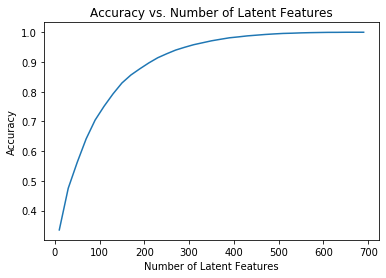

In [36]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructuring with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # taking dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # computing error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # totalling the errors and keeping track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data.  

Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [37]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = set(df_test['user_id'].values)
    test_arts = set(df_test['article_id'].values)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [38]:
# finding all of the train user ids
train_idx = set(df_train['user_id'].values)

# finding the common users in both test and train sets
print(len(train_idx & test_idx))
# finding the users not common in test and train sets
print(len(test_idx) - len(train_idx & test_idx))
# finding total predictions that can be made for the test set
print(len(test_arts))
# finding movies in test set that will encounter cold start problem
print(len(df_test['article_id'].unique()) - len(np.intersect1d(df_train['article_id'].unique(), df_test['article_id'].unique())))

20
662
574
0


In [39]:
# Replacing the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


dict2 = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

print(dict2)

{'How many users can we make predictions for in the test set?': 20, 'How many users in the test set are we not able to make predictions for because of the cold start problem?': 662, 'How many movies can we make predictions for in the test set?': 574, 'How many movies in the test set are we not able to make predictions for because of the cold start problem?': 0}


Using the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then we find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data.
Let's see how well SVD works towards making predictions for recommendations on the test data.  

In [40]:
# fitting SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [41]:
row_index = user_item_train.index.isin(test_idx)
col_index = user_item_train.columns.isin(test_arts)

u_test = u_train[row_index, :]
vt_test = vt_train[:, col_index]

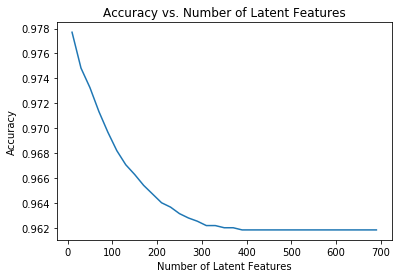

In [42]:
# Finding common indexes in test and training sets
common = list(train_idx & test_idx)
user_item_test = user_item_test.loc[common]

num_latent_feats= np.arange(10, 700+10, 20)
sum_errs=[]

#iterating through latent features to get predictions
for k in num_latent_feats:
    # restructure with k latent features
    u_train_lat, s_train_lat, vt_train_lat = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k,:]
    
    # taking dot product
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    # computing error for each prediction to actual value
    diffs = np.subtract(user_item_test.loc[common, :], user_item_test_preds)
    
    # totalling errors
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
#plotting errors
plt.plot(num_latent_feats,1 - (np.array(sum_errs)/(user_item_test.shape[0]*user_item_test.shape[1])), label='test');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show();

We can observe that as the number of latent features increases, the accuracy on predictions for the test set decreases. Whereas for our training data, the opposite had happened.

The problems arise because the matrix is sparse and the size of test set is very small - only 20 (as the common users between the train and test set are very less). Ideally, the test set needs to be much bigger than that.

It will be better to conduct an AB test where one group can be recommended using rank-based recommendation and the other group can be recommended using matrix-factorization and then compare the result of different recommendation methods.

In [43]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

4294967295